# <center>Tweets Analysis: Malaysia Case Study</center>

I was looking for an idea to do an exploratory analysis project on text data as I want to explore more on NLP. Also I wanted the data to be as raw as possible.The dirtier the better! So, like many others, I googled around and the 10th google search result link, I knew what I wanted to do. 

I am from Malaysia so I figure I want to be the nosy 'makcik bawang' and scrape tweets from Malaysia in the hope that I would know what my fella homies have been tweeting. Hence, this project performed exploratory tweet analyses on tweets originated from Malaysia. The flow of this projects are as follows:

1. Data collection/scrapping using tweepy and Twitter API
2. Data cleaning
3. Data analysis and visualization


## Data Collection
 

I should first cofess that I never tweets although I did have a Twitter account and also never used tweets data before. My first attempt of scrapping tweets data was using Selenium just because it doesn't require access credential from Twitter API (cause I didn't have one at that time). Unfortunately it was too slow and the amount of data that I was able to fetch was not to my expectation and further more I came accross a blog saying that it's illegal to fetch Twitter data without using access credential from Twitter API. So I then turned to Tweepy and end up setting up a Twitter developer account to get the access credential needed. Setting up the developer account was a breeze.

Below are the codes I used to import tweepy and define the access credential required when using the API. The Tweepy class that support OAuth access is called OAuthHandler. All credentials were passed using this class to gain access to Twitter API.


In [1]:
## importing tweepy
import tweepy
from tweepy import OAuthHandler
import csv

consumer_key = "CONSUMER KEY"
consumer_secret = "CONSUMER SECRET"
access_token = "ACCESS TOKEN"
access_secret = "ACCESS SECRET"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

To fetch tweets originated from Malaysia, I used geo_search API to get the place_id parameter for Malaysia, and used this id together with Tweepy Cursor object to filter tweets that I want. I fetched around 100000 tweets ending on 2019/10/25.

For each tweets, the time at which tweets created, the tweets and the tweets location were fetched and saved in a .csv file.

In [ ]:
places = api.geo_search(query="Malaysia")
place_id = places[0].id

csvFile = open('Malaysia.csv', 'w', encoding='utf-8',newline='')
csvWriter = csv.writer(csvFile)

tweets = tweepy.Cursor(api.search,q="place:%s" % place_id,lang="en",count=100,until="2019-10-25").items(100000)

for tweet in tweets:    
    csvWriter.writerow([tweet.created_at, tweet.text,tweet.place.name])
    
csvFile.close()

## Data Cleaning and pre-Processing


Now that I have the necessary raw data, the next thing is to take a peek at the data and starts the cleaning process.

In [2]:
import pandas as pd
data=pd.read_csv('data_Malaysia.csv')
data.head(20)

,Date,Text,Place
0,10/24/2019 23:59,@syakirahkay22 Offer Maybelline ke sis?,Belanja
1,10/24/2019 23:59,The Wallows / Are You Bored Yet? (feat. Clairo),Petaling
2,10/24/2019 23:59,Let’s hustle demi hasil 💪🏼,Kuala Lumpur
3,10/24/2019 23:59,@cheminahsayang proud of you Tuanku 👏🏻👏🏻👏🏻,Kota Kinabalu
4,10/24/2019 23:59,@xaniszulhapilix Onz bui @41M4N95,Kuala Lumpur City
5,10/24/2019 23:59,@Hermend_ used to 😂,Samarahan
6,10/24/2019 23:59,Slept at 3am. Woke up 7am. Hello Barai-ness ✌🏻😬,Petaling
7,10/24/2019 23:59,hey good morning 🌸,George Town
8,10/24/2019 23:59,Testimg daytime https://t.co/P57Y1XM9Ow,Resort Hotel
9,10/24/2019 23:59,hahahahah 🤣🤣\r\nlove this https://t.co/qcHH2B5m4I,Cheras


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
Date     100000 non-null object
Text     100000 non-null object
Place    100000 non-null object
dtypes: object(3)
memory usage: 2.3+ MB


The dataframe has 100000 tweet data entries with 3 columns that contains the date, text and place of the tweets.

Looking at the first 20 entries of the dataframe, the first thing that captured my attention when looking at the tweets above is the emojis. My first thought was to get rid of them but then I figured I might want to use them later on, so I decided to put them a separate column.

There are twitter handler, hyperlinks and punctuations which I decided to remove. There are also hashtags which I decided to keep in a separate column for futher analyses.

I took a two step approaches to pre-processed my tweets data. I first processed the items from the tweets that I want to keep such as the hashtags and emojis, putting them in a separate column so that I can easily use them later on. After that I began the cleaning process of the original tweets.

The following code uses regular expression library to look for the string with hashtag and save them in 'Hashtags' column. 


Note: This is much faster than using dataFrame.apply method

In [4]:
import re

data['Hashtags'] =  [re.findall(r"#\w+",x) for x in data['Text']]

The next thing is to extract the emojis from the tweets and save them in a separate column. To do this, I used emoji module that contains a dictionary of commonly used emoji and regex module that can extract graphemes from text.  

There are two steps involved when extracting emojis from tweets. The first is to split the tweets on graphemes level using regex module. The 'regex.findall(r'\X', text) function output a list of single unicode graphemes from the given text.

The second step is to compare each graphemes with emojis in emoji list. Any emoji (if any) from the list will then be appended into a new list (for each tweets).

The following code performed the steps explained above and the code after that keep emojis from each tweets in a separate column in the dataframe.

In [5]:
import regex
import emoji
emojis=emoji.UNICODE_EMOJI

In [6]:
def return_emoji(text):
    emoji_list = []
    data = regex.findall(r'\X', text)    
    for word in data:
        if any(char in emojis for char in word):
            emoji_list.append(word)

    return emoji_list 

In [7]:
data['Emoji'] =  [return_emoji(x) for x in data['Text']]

Finally, after pre-processing tweets text to get items that I want to keep, I can now proceed to clean the orginal tweets for further analyses.

Most of the cleaning involved string operation such as removing and replacing part of string and hence I used the regular expression library for this process.

Cleaned texts are then kept in a separate column in the dataframe.

In [8]:
import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def cleaner(tweet):    
    tweet = re.sub(r'\&\w*;', '', tweet) # remove HTML &    
    tweet = re.sub(r'#\w*', '', tweet) # remove hashtags   
    tweet = re.sub('@[^\s]+','',tweet) # remove twitter handler   
    tweet = re.sub(r'\$\w*', '', tweet) # remove tickers       
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet) # remove hyperlinks       
    tweet = re.sub(r'[' + string.punctuation + ']+', ' ', tweet) 
    tweet = re.sub(r'\s\s+', ' ', tweet) # remove white space   
    tweet = re.sub(r'\b\w{,3}\b','',tweet)
    tweet = tweet.lower() # to lower case    
    tweet = tweet.lstrip(' ') # remove space at the end    
    tweet = "".join(c for c in tweet if c not in emoji.UNICODE_EMOJI  )        
    tweet=tweet.split()
    tweet=[x for x in tweet if len(x) >2] # remove very short words
    tweet=[x for x in tweet if x not in stop_words] # remove common words
    return tweet
    

In [9]:
data['Cleaned_text'] =  [cleaner(x) for x in data['Text']]

In [10]:
data['Size']=[len(x) for x in data['Cleaned_text']+data['Emoji']+data['Hashtags']]

Let's look at the pre-processed dataframe before proceeding to the analyses step.

In [11]:
data.head()

,Date,Text,Place,Hashtags,Emoji,Cleaned_text,Size
0,10/24/2019 23:59,@syakirahkay22 Offer Maybelline ke sis?,Belanja,[],[],"[offer, maybelline]",2
1,10/24/2019 23:59,The Wallows / Are You Bored Yet? (feat. Clairo),Petaling,[],[],"[wallows, bored, feat, clairo]",4
2,10/24/2019 23:59,Let’s hustle demi hasil 💪🏼,Kuala Lumpur,[],[💪🏼],"[hustle, demi, hasil]",4
3,10/24/2019 23:59,@cheminahsayang proud of you Tuanku 👏🏻👏🏻👏🏻,Kota Kinabalu,[],"[👏🏻, 👏🏻, 👏🏻]","[proud, tuanku]",5
4,10/24/2019 23:59,@xaniszulhapilix Onz bui @41M4N95,Kuala Lumpur City,[],[],[],0


## Data Analyses and Visualisation

Before I started the project, I have several questions at the back of my mind that I would like to explore using the data. The following outlined those questions that would then served as guidelines for the analyses in this part of the project.

1. What do Malaysian like to tweets about?
2. When do Malaysian like to tweets?
3. Where?
4. What emoji do Malaysian like to use?
5. Any favourite hashtags?


Now that I have pre-processed the tweets, they are now ready for further analyses, the first thing that I would like to see is the distribution of the tweets size. For this part of the project, I will be using plotly interactive visualization library.(You need to also install cufflinks if you want to run plotly on jupyter notebook) 

In [12]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(offline=False, world_readable=True)

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [13]:
data['Size'].iplot(kind='hist',bins=50,xTitle='Tweets Size',linecolor='black',yTitle='Count',title='Tweets Size Distribution')


It seems that the highest frequency of tweets size are 2 and 3 and there are also some long tweets of sizes more than 50 words. 

Next, let's look at the choice of words used in the tweets. To count the frequency of the words, I used Counter class from the collections library. There is also another way to compute frequency in a dataframe, that will come later, towards the end of this analyses. For now, let's just use this Counter class and print the top 20 highest number of words used.

In [14]:
from collections import Counter

words = [word for each_row in data['Cleaned_text'] for word in each_row]
Counter(words).most_common(20)

[('like', 3258),
 ('good', 3032),
 ('love', 2891),
 ('time', 2530),
 ('know', 2198),
 ('need', 2132),
 ('thank', 1913),
 ('happy', 1790),
 ('want', 1773),
 ('people', 1707),
 ('still', 1640),
 ('best', 1562),
 ('morning', 1538),
 ('life', 1445),
 ('always', 1418),
 ('back', 1354),
 ('thanks', 1329),
 ('really', 1302),
 ('okay', 1301),
 ('dont', 1298)]

Overall, strong positive choice of words, with the word 'like' as the most commonly used word. Maybe I should run a sentiment analysis on these words and get their scores in the next project.

For the time being, let's use the great plotly to plot the top 20 most frequent words.

In [15]:
df = pd.DataFrame(Counter(words).most_common(20), columns = ['word' , 'count'])
df.groupby('word').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count',xTitle='Words', linecolor='black', title='Top 20 Frequently Used Words')

Wordcloud is another good visualisation tools when dealing with text data. It provides a rather subtle way to visualize information without clouding the screen with nitty-gritty details such as numbers from tables and plots.

In [16]:
from wordcloud import WordCloud
wordcloud=WordCloud().generate(" ".join(words))

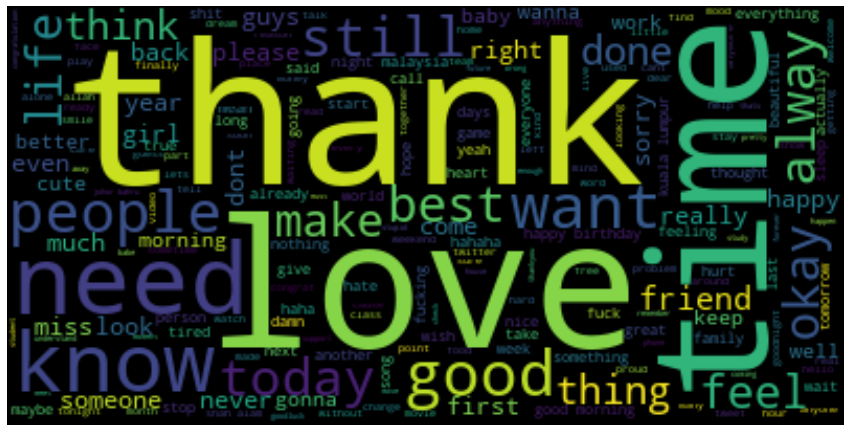

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now that I pretty much know the choice of words used by the tweeters, the next question is when did they tweets. My guess would probably late at night but let's see.

In [18]:
data['Date']=pd.to_datetime(data['Date']) # convert to datetime data type
data['hour'] = data.Date.dt.hour  # extracting only the hour
df_hr=pd.DataFrame(data['hour'].value_counts().reset_index()) # create a separate dataframe to get the frequency for each hour
df_hr.columns=['Hour','count'] # setting the columns
df_hr=df_hr.sort_values(by=['Hour']) # sort by ascending order to track the movement
df_hr['Hour']=[str(x)+':00' for x in df_hr['Hour']]
df_hr.set_index('Hour')
df_hr.iplot(x='Hour',y='count',title='Tweets Time',xTitle='Time',yTitle='Count')

And voila!! It's during lunch time or at the end of lunch break!! Highest not of tweets were generated around 2.00pm. This is a surprise for me. Maybe they tweeting about food. Nope! I didn't see any food related words in the previous analyses. I think when your tummy is happy so is your tweet!

After lunch break. the number of tweets seems to go down and pick up again after dinner. Yes, Malaysian normally have dinner around 8.00- 9.00 pm. There goes my diet!

Next in line is to plot number of tweets generated by places. In this plot, I took the top 20 places that have highest number of tweets.

In [19]:
data.groupby('Place').count()['Text'].sort_values(ascending=False)[:20].iplot(kind='bar', yTitle='Count', linecolor='black', title='Tweets Place')

As I expected, most tweets came from Klang Valley area which are Kuala Lumpur, Damansara and etc. Other big cities outside Klang Valley that made it to the list are Kuching and Kota Kinabalu which are in East Malaysia. 

Moving on, let's look at the choice of hashtags used in the tweets and plot the hashtagCloud.

In [20]:
hashtag=[" ".join(x) for x in data['Hashtags'] if len(x)>0]

In [21]:
pd.DataFrame(Counter(hashtag).most_common(10), columns = ['hashtag' , 'count'])

,hashtag,count
0,#MyTwitterAnniversary,102
1,#MUNLIV,42
2,#YNWA,39
3,#GGMU,28
4,#Endomondo #endorphins,25
5,#Maleficent,23
6,#LoseYouToLoveMe,22
7,#EmeryOut,21
8,#JOOX,21
9,#Repost,19


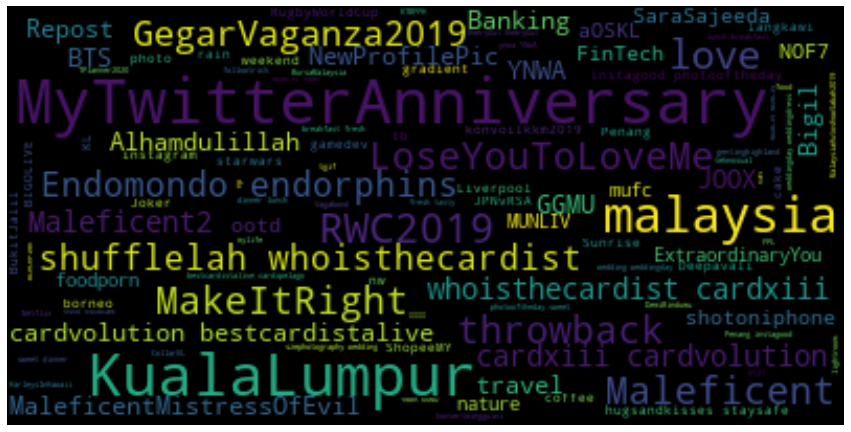

In [22]:
hastagcloud = WordCloud().generate(" ".join(hashtag))
plt.figure(figsize=(15,10))
plt.imshow(hastagcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Hashtag 'MyTwitterAnniversary' is the winner. Maleficent also made it to the list with some other acronyms.

Finally, let's look at the choice of emoji used in the tweets.I printed out the top 10 emojis used.

In [23]:
Emoji=[x for x in data['Emoji'] if x]
Emoji = [item for items in Emoji for item in items]
df_Emoji=pd.DataFrame(Emoji,columns=['Emoji'])

In [24]:
df_Emoji['Emoji'].value_counts()[:10]

😭     4437
😂     4241
❤️    2620
😍     2527
🤣     1784
🥺     1519
🥰     1373
😘     1160
✨      811
💕      795
Name: Emoji, dtype: int64

I am surprise to see that the most frequently used emoji is the crying face since most of the highly frequent used words are strong positive words. Tears of joy probably. The next most frequent emojis is the laughing face. Two opposite emotions there. 


Nevertheless, half of the top 10 most frequently used emojis have somekind of hearts or loves. 

## Conclusions

-  This work performed an exploratory analysis on tweets originated from Malaysia. 
-  The first part of the project performed twitter scrapping technique using Tweepy and Twitter API.
-  100000 tweets were fetched using the API in which Tweepy geo search API was used to filter tweets created from Malaysia.
-  Plotly served as the interactive visualisation tools in this project.
-  I started the analyses by looking at the tweets size distribution.
-  I then looked at the common choice of words used in the tweets followed by the time tweets were generated.
-  The 20 to frequently used words are generally strong positive words and tweets mostly generated around 2.00pm.
-  Tweeters mostly from Klang Valley.
-  Sad crying face emoji was used the most followed by happy laughing face.
  
